# Installations

In [1]:
pip install pandas openpyxl

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install micropip

Note: you may need to restart the kernel to use updated packages.


# Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import random
import time
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import statistics 
from scipy.signal import medfilt
import time 
import concurrent.futures 
from sklearn.linear_model import Ridge

# Utility functions

In [4]:
def compute_fourier_transform(f):
    """
    Compute the Fourier transform of the function f using NumPy's built-in FFT.
    """
    return np.fft.fft(f) / np.sqrt(len(f))

def inverse_fourier_transform(f_fft):
    """
    Compute the inverse Fourier transform of the function \widehat{f}.
    """
    return np.fft.ifft(f_fft) * np.sqrt(len(f_fft))


def find_slots(input_list, value):
    # Use a list comprehension to find the indices where the value occurs
    return [i for i, x in enumerate(input_list) if x == value]

def moduli(complex_list):
    # Use list comprehension to compute the modulus of each complex number
    return [abs(z) for z in complex_list]


def pc(x, y):
    if len(x) != len(y):
        raise ValueError("Both lists must have the same length")

    n = len(x)
    mean_x = sum(x) / n
    mean_y = sum(y) / n

    numerator = sum((x[i] - mean_x) * (y[i] - mean_y) for i in range(n))
    denominator = math.sqrt(sum((x[i] - mean_x) ** 2 for i in range(n)) * sum((y[i] - mean_y) ** 2 for i in range(n)))

    if denominator == 0:
        return 0  # If the denominator is 0, return 0 (no correlation)

    return numerator / denominator

def rl(L, M):
    return [L[x] for x in M]

def compute_norm_complement(f, M):
    """
    Computes the norm of f over the complement of M (M^c).
    
    Parameters:
        f (list of float): A list of real numbers representing f: Z_N -> R.
        M (set of int): A set of indices corresponding to missing values.
        
    Returns:
        float: The computed norm.
    """
    N = len(f)
    # Ensure indices in M are valid
    if any(index < 0 or index >= N for index in M):
        raise ValueError("Indices in M must be within the range of f.")
    
    # Compute the complement of M
    M_complement = {x for x in range(N)} - M
    
    # Compute the sum of squared values over M^c
    sum_squared = sum(f[x]**2 for x in M_complement)
    
    # Return the square root of the sum
    return math.sqrt(sum_squared)

def STD(L):
    return statistics.stdev(L)

<>:8: SyntaxWarning: invalid escape sequence '\w'
<>:8: SyntaxWarning: invalid escape sequence '\w'
C:\Users\spenc\AppData\Local\Temp\ipykernel_63908\2271740037.py:8: SyntaxWarning: invalid escape sequence '\w'
  """


# Data sets

In [7]:
# inflation data
dg = pd.read_csv('datasets/inflation.csv')
rolling_avg = dg['T10YIE'].rolling(window=3, min_periods=1).mean()
dg['T10YIE'] = dg['T10YIE'].fillna(rolling_avg)
inflation_list = list(dg['T10YIE'])

# australia beer production data
beer_set = pd.read_csv('datasets/Australia Monthly Beer Production.csv')
beer_list = list(beer_set['y'])

# dehli climate data
climate_set = pd.read_csv('datasets/Delhi Daily Climate.csv')
climate_list = list(climate_set['y'])

# electric production data
electric_set = pd.read_csv('datasets/Electric Production.csv')
electric_list = list(electric_set['y'])

# peyton manning production data
peyton_set = pd.read_csv('datasets/Peyton Manning Wikipedia Visits.csv')
peyton_list = list(peyton_set['y'])

# Trigonometric ridge based imputer

In [8]:
import numpy as np
from sklearn.linear_model import Ridge

def trig_imputer_ridge(input_list, M, n, alpha=1.0):
    """
    Approximate the given function using a trigonometric polynomial and impute missing values using ridge regression.
    
    Parameters:
        input_list (list): The observed function values.
        M (set): Indices where the values are missing.
        n (int): Degree of the trigonometric polynomial.
        alpha (float): Regularization parameter for ridge regression.
        
    Returns:
        g_result (list): The approximated function over all indices.
        abs_error (float): Relative absolute error on the missing indices.
        final_error (float): Normalized RMSE-based error on the missing indices.
    """
    N = len(input_list)
    
    # Validate indices
    if not M.issubset(range(N)):
        raise ValueError("M must be a subset of indices in the input list.")
    
    f = np.array(input_list, dtype=float)
    
    # Create the set of observed data indices (not in M)
    not_M = np.array(sorted(set(range(N)) - M))
    
    if not_M.size == 0:
        raise ValueError("There must be some observed data (not all indices are missing).")
    
    # --- Build the design matrix for observed data ---
    angles = 2 * np.pi * np.outer(not_M, np.arange(n + 1)) / N
    X_cos = np.cos(angles)  # Cosine part for all degrees (j = 0, 1, ..., n)
    
    if n >= 1:
        X_sin = np.sin(angles[:, 1:])  # Sine part for j > 0
        X = np.hstack([X_cos, X_sin])  # Combine cosine and sine parts
    else:
        X = X_cos
    
    # Observed outputs
    y = f[not_M]
    
    # --- Fit ridge regression ---
    ridge = Ridge(alpha=alpha, fit_intercept=False)
    ridge.fit(X, y)
    coeffs = ridge.coef_
    
    # --- Reconstruct the full approximated function ---
    angles_all = 2 * np.pi * np.outer(np.arange(N), np.arange(n + 1)) / N
    X_all_cos = np.cos(angles_all)
    
    if n >= 1:
        X_all_sin = np.sin(angles_all[:, 1:])
        X_all = np.hstack([X_all_cos, X_all_sin])
    else:
        X_all = X_all_cos
    
    # Compute the reconstructed signal
    g_result = X_all @ coeffs
    
    # --- Compute error metrics ---
    M_sorted = np.array(sorted(M))
    
    if M_sorted.size > 0:
        f_M = f[M_sorted]
        g_M = g_result[M_sorted]

        # Compute μ
        mu = np.mean(np.abs(f_M)) if len(M) > 0 else 0

        # Compute the numerator for RMSE-based error
        numerator = np.sqrt(np.sum((f_M - g_M) ** 2) / N)

        # Compute the denominator for RMSE-based error
        denominator = np.sqrt(np.sum((f_M - mu) ** 2) / N)

        # Final RMSE-based error metric
        final_error = numerator / denominator if denominator != 0 else float('inf')

        # Compute the original relative absolute error
        abs_numerator = np.sum(np.abs(f_M - g_M))
        abs_denominator = np.sum(np.abs(f_M))
        abs_error = abs_numerator / abs_denominator if abs_denominator > 1e-10 else float('inf')
    
    else:
        abs_error = 0.0
        final_error = 0.0

    return g_result.tolist(), abs_error, final_error

import numpy as np

def degree(input_list, threshold=0.01):
    """
    Estimate the optimal degree n for the trigonometric polynomial by analyzing the frequency spectrum.
    
    Parameters:
        input_list (list): The observed function values.
        threshold (float): Relative threshold for selecting significant frequencies.
        
    Returns:
        n (int): Estimated degree of the trigonometric polynomial.
    """
    N = len(input_list)
    
    # Compute the Fourier Transform
    fft_coeffs = np.fft.fft(input_list)
    magnitudes = np.abs(fft_coeffs)[:N // 2]  # Consider only the positive frequencies
    
    # Normalize magnitudes
    max_magnitude = np.max(magnitudes)
    significant_freqs = np.where(magnitudes > threshold * max_magnitude)[0]
    
    # Choose n as the highest significant frequency
    n = max(significant_freqs) if len(significant_freqs) > 0 else 0
    
    return n



# The $L^1$-optimizer. 

We consider all functins $g(x)$ such that $f(x)=g(x)$ for $x \notin M$ and minimize $\sum_m |\widehat{g}(m)|$. 

In [ ]:
def L1optimizer(input_list, M):
    """
    Optimize a function g to minimize the sum of absolute values of its Fourier coefficients
    while ensuring g(x) equals f(x) for indices x not in the subset M.
    """
    N = len(input_list)  # Length of the input list

    # Ensure M is a subset of {0, 1, ..., N-1}
    if not M.issubset(set(range(N))):
        raise ValueError("M must be a subset of indices in the range of the input list.")

    # Convert input list to a NumPy array
    f = np.array(input_list, dtype=float)

    # Optimization variables
    g = cp.Variable(N, value=f)  # Initialize with the input list f

    # Create a mask for the indices that are not in M
    mask = np.ones(N, dtype=bool)
    mask[list(M)] = False  # Set the indices in M to False (which will be excluded from the constraint)

    # Constraints: g(x) = f(x) for indices not in M
    constraints = [g[mask] == f[mask]]

    # Fourier matrix for the Discrete Fourier Transform
    omega = np.exp(-2j * np.pi / N)  # Primitive Nth root of unity
    F = np.array([[omega ** (x * m) for m in range(N)] for x in range(N)]) / np.sqrt(N)

    # Compute the Fourier transform of g(x) using the Fourier matrix (CVXPY compatible)
    g_fft = F @ g  # Use matrix multiplication for Fourier transform

    # Objective: Minimize sum of the absolute values of the Fourier coefficients (L1 norm)
    objective = cp.Minimize(cp.sum(cp.abs(g_fft)))

    # Problem definition
    problem = cp.Problem(objective, constraints)

    try:
        # Solve the problem using the SCS solver
        problem.solve(solver=cp.SCS, verbose=False)

        if problem.status != cp.OPTIMAL:
            raise ValueError("Optimization failed to find a solution.")

    except Exception as e:
        print(f"Error occurred: {e}")
        return None, None, None  # Handle failure appropriately

    # Extract the optimized g(x)
    g_result = g.value

    if g_result is None:
        print("Optimization did not return a valid result.")
        return None, None, None

    # Compute error measurements
    f_M = f[list(M)]
    g_M = g_result[list(M)]

    # Compute μ
    mu = np.mean(np.abs(f_M)) if len(M) > 0 else 0

    # Compute the numerator for RMSE-based error
    numerator = np.sqrt(np.sum((f_M - g_M) ** 2) / N)

    # Compute the denominator for RMSE-based error
    denominator = np.sqrt(np.sum((f_M - mu) ** 2) / N)

    # Final RMSE-based error metric
    final_error = numerator / denominator if denominator != 0 else float('inf')

    # Compute the original relative absolute error
    abs_numerator = np.sum(np.abs(f_M - g_M))
    abs_denominator = np.sum(np.abs(f_M))
    abs_error = abs_numerator / abs_denominator if abs_denominator != 0 else float('inf')

    return g_result.tolist(), abs_error, final_error


# An improved $L^1$-optimizer

The following versio of the L1optimizer does not insist that $f(x)=g(x)$ for $x \notin M$. Instead, we just insist that 
$ {\left( \frac{1}{N-|M|} \sum_{x \notin M} {|f(x)-g(x)|}^2 \right)}^{\frac{1}{2}}<\epsilon,$ where $\epsilon$ is a parameter to be chosen. 

## Mathematical Description of `estimate_epsilon`

Given a time series $ f = (f_0, f_1, \dots, f_{N-1}) $ of length $ N $, where some indices $ M \subset \{0,1,\dots,N-1\} $ correspond to missing values, we aim to estimate an appropriate parameter $ \epsilon $ for robust imputation.

### Step 1: Detrending
To remove low-frequency variations, we apply a median filter with a kernel size $ k_s $ (typically an odd integer):

$$
\tilde{f}_i = \text{medfilt}(f, k_s)
$$

where $ \tilde{f}_i $ is the filtered version of $ f $. The detrended signal is then:

$$
d_i = f_i - \tilde{f}_i, \quad i = 0,1,\dots,N-1
$$

### Step 2: Extract Observed Detrended Values
Define the set of observed indices:

$$
M^c = \{0,1,\dots,N-1\} \setminus M
$$

The detrended observed values are:

$$
d_{\text{obs}} = \{ d_i \mid i \in M^c \}
$$

### Step 3: Noise Level Estimation
We estimate the noise level $ \sigma $ using one of the following methods:

1. **Median Absolute Deviation (MAD)**:
   - Compute the median of the observed detrended values:

   $$
   m = \text{median}(d_{\text{obs}})
   $$

   - Compute the MAD:

   $$
   \text{MAD} = \text{median}(|d_{\text{obs}} - m|)
   $$

   - Estimate the standard deviation using the asymptotic relation:

   $$
   \sigma \approx \frac{\text{MAD}}{0.6745}
   $$

   If $ \text{MAD} = 0 $, fallback to the standard deviation of $ d_{\text{obs}} $.

2. **Difference-Based Estimation**:
   - Compute the first-order differences:

   $$
   \Delta d_{\text{obs}} = \{ d_{\text{obs}, i+1} - d_{\text{obs}, i} \}
   $$

   - Estimate $ \sigma $ using:

   $$
   \sigma \approx \frac{\text{std}(\Delta d_{\text{obs}})}{\sqrt{2}}
   $$

   If there is only one observed point, use the standard deviation of $ d_{\text{obs}} $.

### Step 4: Compute $ \epsilon $
Finally, $ \epsilon $ is set as a multiple of the estimated noise level:

$$
\epsilon = k \sigma
$$

where $ k $ is a user-defined scaling factor (default: $ k = 0.5 $).


In [10]:
def L1epsilonoptimizer(input_list, M, epsilon):
    """
    Optimize g to minimize the L1 norm of its Fourier coefficients subject to:
      (1/\u221a(N-|M|)) * || f(x) - g(x) ||_2 <= epsilon for x \u2209 M.
    """
    N = len(input_list)
    if not M.issubset(set(range(N))):
        raise ValueError("M must be a subset of valid indices.")
    
    # Compute indices (observed and missing)
    M = np.array(sorted(list(M)))
    M_complement = np.array(sorted(list(set(range(N)) - set(M))))
    if len(M_complement) == 0:
        raise ValueError("M cannot equal the full index set.")

    f = np.array(input_list, dtype=float)
    
    # Define optimization variable
    g = cp.Variable(N)
    
    # Precompute Fourier matrix
    F = np.fft.fft(np.eye(N)) / np.sqrt(N)
    g_fft = F @ g

    # Define the objective: minimize the L1 norm of the Fourier coefficients.
    objective = cp.Minimize(cp.norm1(g_fft))
    
    # Data fidelity constraint
    constraints = [
        cp.norm2(f[M_complement] - g[M_complement]) / np.sqrt(len(M_complement)) <= epsilon
    ]
    
    # Define and solve the problem
    problem = cp.Problem(objective, constraints)
    try:
        problem.solve(solver=cp.SCS, verbose=False)
        if problem.status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
            raise ValueError("Optimization did not converge optimally.")
    except Exception as e:
        print(f"Error: {e}")
        return None, None, None
    
    g_result = g.value
    if g_result is None:
        print("No valid solution was returned.")
        return None, None, None
    
    # Compute error measurements
    f_M = f[list(M)]
    g_M = g_result[list(M)]

    # Compute mean of absolute f_M values
    mu = np.mean(np.abs(f_M)) if len(M) > 0 else 0

    # Compute numerator for RMSE-based error
    numerator = np.sqrt(np.sum((f_M - g_M) ** 2) / N)

    # Compute denominator for RMSE-based error
    denominator = np.sqrt(np.sum((f_M - mu) ** 2) / N)

    # Final RMSE-based error metric
    final_error = numerator / denominator if denominator != 0 else float('inf')

    # Compute the original relative absolute error
    abs_numerator = np.sum(np.abs(f_M - g_M))
    abs_denominator = np.sum(np.abs(f_M))
    abs_error = abs_numerator / abs_denominator if abs_denominator != 0 else float('inf')

    return g_result.tolist(), abs_error, final_error

def estimate_epsilon_old(input_list, M, method='mad', k=0.5, kernel_size=5):
    """
    Estimate an appropriate epsilon for imputation based on the noise level in the observed data,
    after detrending using a median filter to remove slow-varying signal components.
    
    The noise level is estimated on the detrended observed data. The computed epsilon is
        epsilon = k * sigma,
    where sigma is the estimated noise standard deviation.
    
    Parameters
    ----------
    input_list : list or array-like
        The complete time series (including missing entries at indices given by M).
    M : set or list
        The indices corresponding to missing values.
    method : str, optional
        Method to estimate the noise level from the detrended data. Options are:
            'mad'  : Use the median absolute deviation.
            'diff' : Use the standard deviation of differences for consecutive observed points.
        Default is 'mad'.
    k : float, optional
        Scaling factor to set epsilon. Default is 0.5.
    kernel_size : int, optional
        The kernel size for the median filter. Must be a positive odd integer. Default is 5.
    
    Returns
    -------
    epsilon : float
        The estimated value of epsilon.
    
    Raises
    ------
    ValueError
        If M contains invalid indices or if there is not enough observed data to estimate noise.
    """
    # Convert input_list to a NumPy array and determine its length.
    f = np.array(input_list, dtype=float)
    N = len(f)
    
    # Validate that M is a subset of valid indices.
    if not set(M).issubset(set(range(N))):
        raise ValueError("M must be a subset of indices in the input list.")
        
    # Identify observed indices (i.e., indices not in M)
    observed_indices = np.array(sorted(list(set(range(N)) - set(M))))
    if observed_indices.size == 0:
        raise ValueError("No observed data available for noise estimation.")
    
    # Apply a median filter to detrend the data.
    detrended = f - medfilt(f, kernel_size=kernel_size)
    
    # Extract detrended observed values.
    observed_detrended = detrended[observed_indices]
    
    # Estimate noise sigma using the specified method on the detrended signal.
    if method == 'mad':
        # Use the median absolute deviation as a robust estimator.
        median_val = np.median(observed_detrended)
        mad = np.median(np.abs(observed_detrended - median_val))
        sigma = mad / 0.6745 if mad != 0 else np.std(observed_detrended)
    elif method == 'diff':
        # Use differences between consecutive observed points (if consecutive).
        diffs = np.diff(observed_detrended)
        sigma = np.std(diffs) / np.sqrt(2) if len(diffs) > 1 else np.std(observed_detrended)
    else:
        raise ValueError("Unknown method. Use 'mad' or 'diff'.")
    
    # Set epsilon to be a multiple of the estimated noise level.
    epsilon = k * sigma
    return epsilon

import numpy as np
from scipy.signal import medfilt

def estimate_epsilon(input_list, M, method='mad', k=0.5, kernel_size=5):
    """
    Estimate an appropriate epsilon for imputation based only on observed data,
    avoiding data leakage from missing entries.
    """
    f = np.array(input_list, dtype=float)
    N = len(f)

    if not set(M).issubset(set(range(N))):
        raise ValueError("M must be a subset of indices in the input list.")

    observed_indices = np.array(sorted(list(set(range(N)) - set(M))))
    if observed_indices.size == 0:
        raise ValueError("No observed data available for noise estimation.")

    # Create a copy and replace missing values with the median of observed values
    f_masked = f.copy()
    observed_values = f[observed_indices]
    fill_value = np.median(observed_values)
    f_masked[list(M)] = fill_value  # Could also use np.nan with a nan-aware filter

    # Apply the median filter to the masked signal
    trend = medfilt(f_masked, kernel_size=kernel_size)

    # Detrend the original signal
    detrended = f - trend

    # Extract detrended values only at observed indices
    observed_detrended = detrended[observed_indices]

    # Estimate noise level from the detrended signal
    if method == 'mad':
        median_val = np.median(observed_detrended)
        mad = np.median(np.abs(observed_detrended - median_val))
        sigma = mad / 0.6745 if mad != 0 else np.std(observed_detrended)
    elif method == 'diff':
        diffs = np.diff(observed_detrended)
        sigma = np.std(diffs) / np.sqrt(2) if len(diffs) > 1 else np.std(observed_detrended)
    else:
        raise ValueError("Unknown method. Use 'mad' or 'diff'.")

    epsilon = k * sigma
    return epsilon

# Testing ground

In [ ]:
num_run = 50
a1, a2, a3 = 0, 0, 0
T = inflation_list[600:1050]
M=set(sorted([random.randint(1, 449) for _ in range(150)]))

# Function to run the optimization methods and return the results
def run_optimization(count, T, M):
    # Run L1epsilonoptimizer
    result_a1 = L1epsilonoptimizer(T, M, estimate_epsilon(T, M, method='diff', k=0.5, kernel_size=5))
    
    # Run L1optimizer
    result_a2 = L1optimizer(T, M)
    
    # Run trig_imputer_ridge
    result_a3 = trig_imputer_ridge(T, M, 3)

    # Return the results
    return (result_a1[1], result_a2[1], result_a3[1])

# Start the total timer before the loop
start_time = time.time()

# Initialize the final results
results = []

# Use ProcessPoolExecutor or ThreadPoolExecutor for parallelism
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Generate random M for each run and execute each task in parallel
    future_to_run = {executor.submit(run_optimization, count, T, set(sorted([random.randint(1, 449) for _ in range(148)]))): count for count in range(num_run)}

    # Wait for all the futures to complete
    for future in concurrent.futures.as_completed(future_to_run):
        try:
            result = future.result()  # Get the result of the task
            count = future_to_run[future]  # Retrieve the count corresponding to this future
            
            # Accumulate the results
            a1 += 100 * (1 - result[0])
            a2 += 100 * (1 - result[1])
            a3 += 100 * (1 - result[2])

        except Exception as e:
            print(f"Error in run {count + 1}: {e}")

# End the total timer after the loop
end_time = time.time()
elapsed_time = end_time - start_time

# Display the average results and the total time taken
print(f"Average Results: a1 = {a1 / num_run}, a2 = {a2 / num_run}, a3 = {a3 / num_run}")
print(f"Total time taken for {num_run} runs: {elapsed_time:.2f} seconds")

Average Results: a1 = 98.66708595091501, a2 = 98.59997487967976, a3 = 96.98088279673495
Total time taken for 50 runs: 139.13 seconds


# Visualization

c:\Tools\Lib\site-packages\scs\__init__.py:96: UserWarning: Converting A to a CSC (compressed sparse column) matrix; may take a while.
  warn(


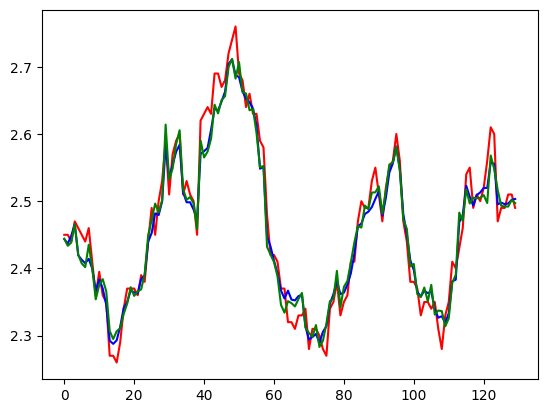

In [ ]:
T = inflation_list[400:850]
M=set(sorted([random.randint(1, 449) for _ in range(150)]))

plt.plot(rl(T,M), color = 'red'), 
plt.plot(rl(L1epsilonoptimizer(T, M, estimate_epsilon(T, M, method='diff'))[0],M), color = 'blue'),
plt.plot(rl(L1optimizer(T, M)[0],M), color = 'green') 
# plt.plot(rl(trig_imputer_ridge(T, M, 2)[0],M), color = 'black') 

In [12]:
L1epsilonoptimizer(T, M, estimate_epsilon(T, M, method='diff'))[1]

np.float64(0.008259273104921605)

In [13]:
trig_imputer_ridge(T, M, 2)[1]

np.float64(0.03201660400201092)

In [14]:
L1optimizer(T, M)[2]

c:\Tools\Lib\site-packages\scs\__init__.py:96: UserWarning: Converting A to a CSC (compressed sparse column) matrix; may take a while.
  warn(


np.float64(0.22853723101359605)

In [17]:
T = inflation_list[400:850]
M=set(sorted([random.randint(1, 449) for _ in range(150)]))
a = 0

for i in range(1000):
    a += 100 * (1 - trig_imputer_ridge(T, M, degree(T))[1])
    
print(f"Average Results:a = {a / 1000}") 

Average Results:a = 98.3830516744892


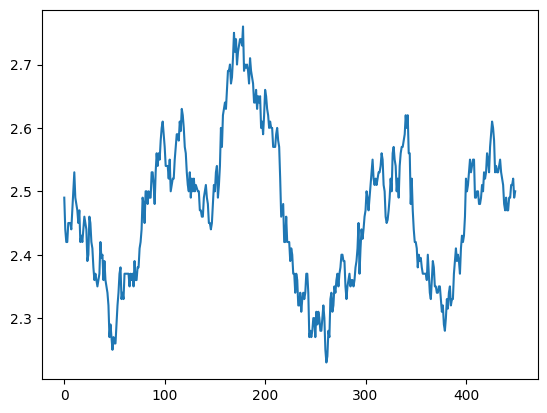

In [ ]:
plt.plot(inflation_list[400:850])